<a href="https://colab.research.google.com/github/Ahmed-Magdi1/2DOF-Helicopter-NARX/blob/v.2/NARX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Important libraries
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [4]:
# Load input and output CSV files
inputs = pd.read_csv('input.csv')  # Contains: V, I_pitch, I_yaw
outputs = pd.read_csv('output.csv')  # Contains: pitch_angle, yaw_angle

# Convert to arrays
X = inputs.values  # Shape: (samples, features)
Y = outputs.values  # Shape: (samples, targets)

##Normalize the Data

In [5]:
# Normalize the Data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

##Lagged Features

In [19]:
# Create Lagged Features for NARX Model
def create_lagged_data(inputs, outputs, input_lag, output_lag):
    X_lagged, Y_lagged = [], []
    for t in range(max(input_lag, output_lag), len(inputs)):
        x_lagged = inputs[t-input_lag:t].flatten()
        y_lagged = outputs[t-output_lag:t-1].flatten()
        X_lagged.append(np.hstack((x_lagged, y_lagged)))
        Y_lagged.append(outputs[t])
    return np.array(X_lagged), np.array(Y_lagged)

##Lagged Data

In [20]:
# Define input and output lags
input_lag = 3
output_lag = 2

# Generate lagged data
X_lagged, Y_lagged = create_lagged_data(X_scaled, Y_scaled, input_lag, output_lag)
X_train, X_test, Y_train, Y_test = train_test_split(X_lagged, Y_lagged, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

##Define the Feedforward Neural Network

In [21]:
# Define the NARX neural network
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),  # Input: lagged features
    Dense(128, activation='relu'),
    Dense(Y_train.shape[1], activation='linear')  # Output: pitch and yaw angles
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,346 (36.51 KB)

 Trainable params: 9,346 (36.51 KB)

 Non-trainable params: 0 (0.00 B)

##Train the Model

In [117]:
start_time = time.time()
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=200,
    batch_size=128,
    verbose=1
)

training_time = time.time() - start_time

Epoch 1/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9434e-06 - mae: 7.6030e-04 - val_loss: 2.9048e-06 - val_mae: 6.1826e-04
Epoch 2/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9710e-06 - mae: 7.6258e-04 - val_loss: 3.0737e-06 - val_mae: 7.7441e-04
Epoch 3/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1248e-06 - mae: 8.5668e-04 - val_loss: 3.1927e-06 - val_mae: 9.4302e-04
Epoch 4/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0471e-06 - mae: 8.3182e-04 - val_loss: 3.5936e-06 - val_mae: 0.0011
Epoch 5/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0287e-06 - mae: 8.1158e-04 - val_loss: 2.9642e-06 - val_mae: 7.3296e-04
Epoch 6/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8919e-06 - mae: 7.3840e-04 - val_loss: 2.9886e-06 - val_mae: 7.5714e-04
Epoch 7/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8902e-06 - mae: 7.3725e-04 - val_loss: 3.2399e-06 - val_mae: 9.4935e-04
Epoch 8/200
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

##Evaluate the Model

In [118]:
# Evaluate the Model
loss, mae = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3040e-06 - mae: 9.2208e-04
Test Loss: 3.3099020129156997e-06, Test MAE: 0.0009255700861103833


##Predictions

In [119]:
# Predictions
start_time = time.time()
Y_pred_scaled = model.predict(X_test)
inference_time = time.time() - start_time
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_actual = scaler_Y.inverse_transform(Y_test)

# Compute Metrics
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_actual, Y_pred)
r2 = r2_score(Y_actual, Y_pred)

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


##Visualize Results

In [120]:
# Store results
model_results = {
    "Model": "NARX",
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R²": r2,
    "Training Time (s)": training_time,
    "Inference Time (s)": inference_time,
    "Layers": "Input-64-128-Output",
    "Activation Functions": "ReLU, ReLU, Linear",
    "Optimizer": "Adam",
    "Learning Rate": 0.001,
    "Batch Size": 16,
    "Epochs": 100,
    "Loss Function": "MSE"
}

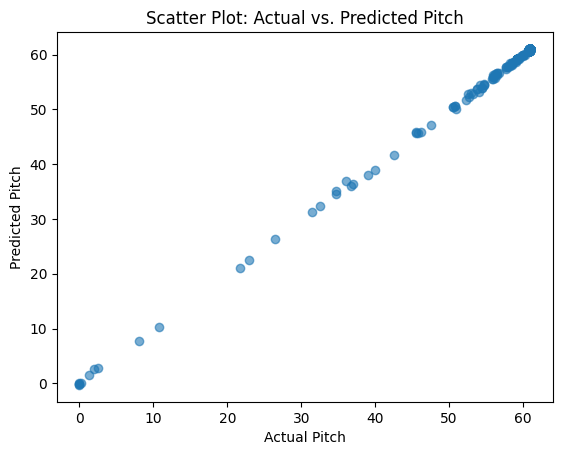

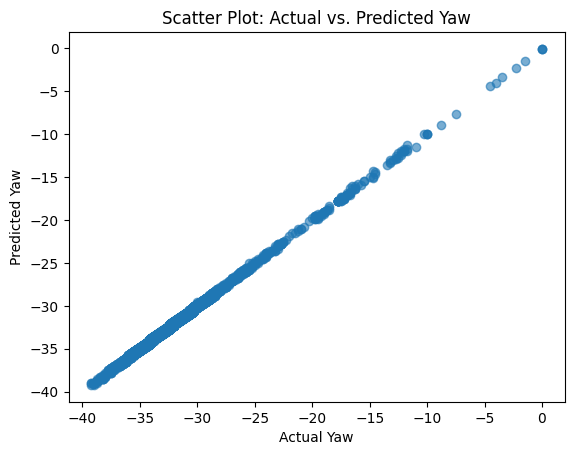

In [121]:
# Scatter plot for Pitch
plt.figure()
plt.scatter(Y_actual[:, 0], Y_pred[:, 0], alpha=0.6)
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Scatter Plot: Actual vs. Predicted Pitch')
plt.show()

# Scatter plot for Yaw
plt.figure()
plt.scatter(Y_actual[:, 1], Y_pred[:, 1], alpha=0.6)
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Scatter Plot: Actual vs. Predicted Yaw')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

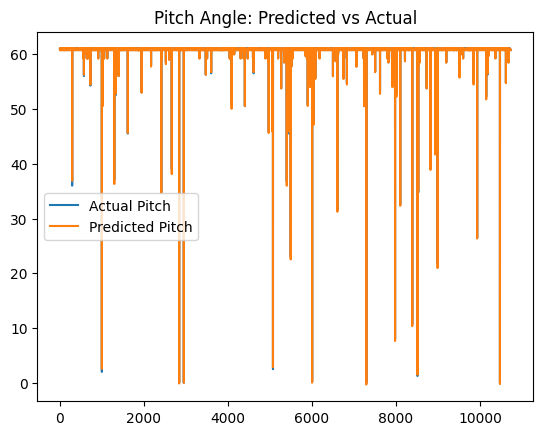

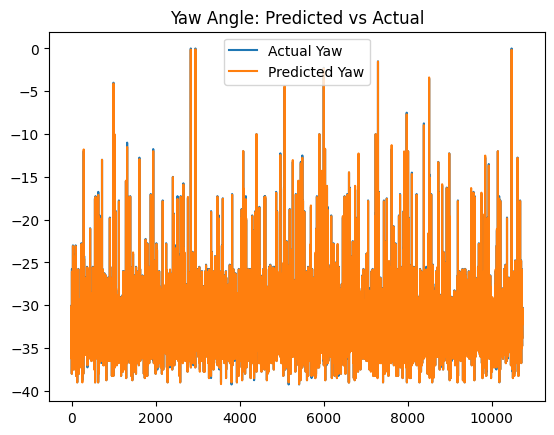

Model saved successfully.


In [122]:
# Save results to Excel
df_results = pd.DataFrame([model_results])
df_results.to_excel("model_performance.xlsx", index=False)

from google.colab import files
files.download("model_performance.xlsx")

# Visualizations
plt.figure()
plt.plot(Y_actual[:, 0], label='Actual Pitch')
plt.plot(Y_pred[:, 0], label='Predicted Pitch')
plt.legend()
plt.title('Pitch Angle: Predicted vs Actual')
plt.show()

plt.figure()
plt.plot(Y_actual[:, 1], label='Actual Yaw')
plt.plot(Y_pred[:, 1], label='Predicted Yaw')
plt.legend()
plt.title('Yaw Angle: Predicted vs Actual')
plt.show()

# Save the Model
model.save('NARX_helicopter_model.h5')
print("Model saved successfully.")
